In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from tensorflow.keras.applications.xception import Xception #to get pre-trained model Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense#Keras to build our CNN and LSTM
from tensorflow.keras.layers import LSTM, Embedding, Dropout

In [23]:
# from tqdm import tqdm_notebook as tqdm #to check loop progress
# tqdm().pandas()

## Defining Functions set 0

In [2]:
# Load the document file into memory
def load_doc(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
# get all images with their captions
def img_capt(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split("\t")
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [4]:
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption.replace("-", " ")
            descp = img_caption.split()
            # uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd) > 1)]
            # remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            # converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

In [5]:
def txt_vocab(descriptions):
  # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [6]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


In [7]:
dataset_text = "C:\\Users\\crkpn\\Documents\\Programs\\img_captions\\Flickr8k_text"
dataset_images = "C:\\Users\\crkpn\\Documents\\Programs\\img_captions\\Flicker8k_Dataset"

In [8]:
#to prepare our text data
filename = dataset_text + "\\" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [9]:
#to prepare our text data
filename = dataset_text + "\\" + "Flickr8k.token.txt"
file = load_doc(filename)
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


## Defining Functions set 1

In [10]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    ct=0
    for pic in os.listdir(directory):
        file = directory + "\\" + pic
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
        ct+=1
        print(ct)
    return features

In [12]:
# Extract 2048 feature vector using Xception model and save them as pickle file
# features = extract_features(dataset_images)
# dump(features, open("features.p","wb"))

# To directly load the features from the pickle file.
features = load(open("features.p","rb"))


In [31]:
features

{'1000268201_693b08cb0e.jpg': array([[0.4733967 , 0.01732628, 0.07333969, ..., 0.08559036, 0.02102286,
         0.23766516]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[0.00158209, 0.11113476, 0.00037395, ..., 0.2650358 , 0.35279816,
         0.0587166 ]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[0.        , 0.0248897 , 0.0155406 , ..., 0.        , 0.        ,
         0.10192642]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[0.14568838, 0.00272412, 0.27776518, ..., 0.17018227, 0.11957318,
         0.09414067]], dtype=float32),
 '1007129816_e794419615.jpg': array([[0.        , 0.12443964, 0.73916227, ..., 0.00390437, 0.00997145,
         0.50172365]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[0.04136695, 0.        , 0.01274471, ..., 0.0094469 , 0.6420165 ,
         0.04792123]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[0.        , 0.        , 0.02624736, ..., 0.30528584, 0.23091778,
         0.14191063]], dtype=float32),
 '1012

## Defining Functions set 2

In [17]:
#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [18]:
def load_clean_descriptions(filename, photos):
    # Load clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words) < 2:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)
    return descriptions

In [19]:
def load_features(photos):
    # Load all features
    all_features = load(open("features.p","rb"))
    # Select only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [20]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [21]:
train_imgs

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [22]:
train_descriptions

{'1000268201_693b08cb0e.jpg': [' child in pink dress is climbing up set of stairs in an entry way ',
  ' girl going into wooden building ',
  ' little girl climbing into wooden playhouse ',
  ' little girl climbing the stairs to her playhouse ',
  ' little girl in pink dress going into wooden cabin '],
 '1001773457_577c3a7d70.jpg': [' black dog and spotted dog are fighting ',
  ' black dog and tricolored dog playing with each other on the road ',
  ' black dog and white dog with brown spots are staring at each other in the street ',
  ' two dogs of different breeds looking at each other on the road ',
  ' two dogs on pavement moving toward each other '],
 '1002674143_1b742ab4b8.jpg': [' little girl covered in paint sits in front of painted rainbow with her hands in bowl ',
  ' little girl is sitting in front of large painted rainbow ',
  ' small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it ',
  ' there is girl with pigtails sitting in front of r

In [23]:
train_features

{'2513260012_03d33305cf.jpg': array([[0.        , 0.44815797, 0.        , ..., 0.17757457, 0.00191516,
         0.00869683]], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([[0.17655936, 0.01287626, 0.15669039, ..., 0.07785643, 0.22157383,
         0.07919029]], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([[0.28786114, 0.        , 0.        , ..., 0.        , 0.08850836,
         0.        ]], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([[0.4536431 , 0.        , 0.        , ..., 0.00685256, 0.        ,
         0.        ]], dtype=float32),
 '2644326817_8f45080b87.jpg': array([[0.00466417, 0.00331445, 0.02121841, ..., 0.07942963, 0.01354533,
         0.        ]], dtype=float32),
 '218342358_1755a9cce1.jpg': array([[0.07323242, 0.01431644, 0.11561771, ..., 0.11935551, 0.07156441,
         0.11425358]], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([[1.10656060e-01, 1.73755936e-04, 3.46862912e-01, ...,
         1.25681255e-02, 1.08910769e-01, 3.87888044e-01]], 

## Defining Functions set 3

In [24]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        for d in descriptions[key]:
            all_desc.append(d)
    return all_desc

In [25]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [34]:
# # from pickle import dump
# # tokenizer = create_tokenizer(train_descriptions)
# # dump(tokenizer, open('tokenizer.p', 'wb'))
# vocab_size = len(tokenizer.word_index) + 1

In [43]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

In [27]:
desc_list = dict_to_list(train_descriptions)

In [28]:
desc_list

[' child in pink dress is climbing up set of stairs in an entry way ',
 ' girl going into wooden building ',
 ' little girl climbing into wooden playhouse ',
 ' little girl climbing the stairs to her playhouse ',
 ' little girl in pink dress going into wooden cabin ',
 ' black dog and spotted dog are fighting ',
 ' black dog and tricolored dog playing with each other on the road ',
 ' black dog and white dog with brown spots are staring at each other in the street ',
 ' two dogs of different breeds looking at each other on the road ',
 ' two dogs on pavement moving toward each other ',
 ' little girl covered in paint sits in front of painted rainbow with her hands in bowl ',
 ' little girl is sitting in front of large painted rainbow ',
 ' small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it ',
 ' there is girl with pigtails sitting in front of rainbow painting ',
 ' young girl with pigtails painting outside in the grass ',
 ' man lays on bench wh

In [44]:
max_length = max_length(train_descriptions)
max_length #Max_length of description is 32

32

In [33]:
import pickle

# Load the tokenizer from file
with open('tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)

# Print the top 10 words and their integer tokens
for word, index in list(tokenizer.word_index.items()):
    print(f"{word}: {index}")


in: 1
the: 2
on: 3
is: 4
and: 5
dog: 6
with: 7
man: 8
of: 9
two: 10
white: 11
black: 12
boy: 13
are: 14
woman: 15
girl: 16
to: 17
wearing: 18
at: 19
people: 20
water: 21
brown: 22
young: 23
red: 24
an: 25
his: 26
blue: 27
dogs: 28
running: 29
through: 30
playing: 31
while: 32
down: 33
shirt: 34
ball: 35
standing: 36
little: 37
grass: 38
snow: 39
child: 40
person: 41
jumping: 42
over: 43
three: 44
sitting: 45
front: 46
field: 47
holding: 48
small: 49
yellow: 50
green: 51
group: 52
up: 53
by: 54
large: 55
one: 56
walking: 57
her: 58
men: 59
children: 60
air: 61
into: 62
near: 63
mouth: 64
beach: 65
jumps: 66
runs: 67
another: 68
for: 69
street: 70
from: 71
its: 72
riding: 73
stands: 74
bike: 75
girls: 76
as: 77
outside: 78
play: 79
rock: 80
other: 81
looking: 82
orange: 83
out: 84
pink: 85
player: 86
next: 87
off: 88
camera: 89
pool: 90
their: 91
jacket: 92
hat: 93
behind: 94
around: 95
boys: 96
women: 97
toy: 98
soccer: 99
some: 100
wall: 101
sits: 102
background: 103
has: 104
dressed: 

In [35]:
vocab_size = len(tokenizer.word_index) + 1

In [36]:
seq = tokenizer.texts_to_sequences([desc_list[0]])


In [37]:
seq

[[40, 1, 85, 167, 4, 115, 53, 391, 9, 392, 1, 25, 4472, 638]]

In [38]:
[desc_list[0]]

[' child in pink dress is climbing up set of stairs in an entry way ']

## Defining Function set 4

In [45]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)

#To check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
print(a.shape, b.shape, c.shape) # should print ((47, 2048), (47, 32), (47, 7577))


(37, 2048) (37, 32) (37, 7577)


## Define the Model

In [46]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [47]:
max_length

32

In [50]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [51]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

# creating a directory named models to save our models
os.mkdir("models")

for i in range(epochs):
    print(i)
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 256)      1939712     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']  

C:\Users\crkpn\OneDrive\Desktop\MongoDB\mongosh-1.5.4-win32-x64\bin\ipykernel_19708\3016242801.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


6000/6000 [==============================] - 649s 108ms/step - loss: 4.9310
1
6000/6000 [==============================] - 641s 107ms/step - loss: 3.9687
2
6000/6000 [==============================] - 637s 106ms/step - loss: 3.6355
3
6000/6000 [==============================] - 644s 107ms/step - loss: 3.4296
4
6000/6000 [==============================] - 640s 107ms/step - loss: 3.2879
5
6000/6000 [==============================] - 645s 107ms/step - loss: 3.1829
6
6000/6000 [==============================] - 642s 107ms/step - loss: 3.0942
7
6000/6000 [==============================] - 643s 107ms/step - loss: 3.0302
8
6000/6000 [==============================] - 643s 107ms/step - loss: 2.9758
9
6000/6000 [==============================] - 641s 107ms/step - loss: 2.9179


# train our model on 5 images
train_imgs_small = train_imgs[:5]
train_descriptions_small = {k:train_descriptions[k] for k in train_imgs_small}
train_features_small = {k:train_features[k] for k in train_imgs_small}

print('Dataset: ', len(train_imgs_small))
print('Descriptions: train=', len(train_descriptions_small))
print('Photos: train=', len(train_features_small))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model_small = define_model(vocab_size, max_length)

epochs = 2
steps = len(train_descriptions_small)
# creating a directory named models to save our models
os.mkdir("models_small")
for i in range(epochs):
    generator = data_generator(train_descriptions_small, train_features_small, tokenizer, max_length)
    model_small.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model_small.save("models_small/model_" + str(i) + ".h5")


In [52]:
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
        return None
    image = image.resize((299,299))
    image = np.array(image)
    # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [65]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


1/1 [==============================] - 1s 647ms/step

Generated Caption: their dog are playing with toy in the water with ball in his mouth and


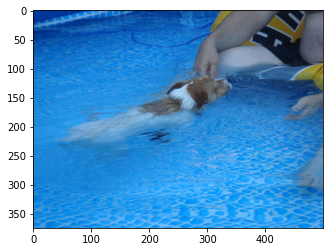

1/1 [==============================] - 0s 31ms/step

Generated Caption: basketball player in red uniform is playing basketball with the goal arts during game of


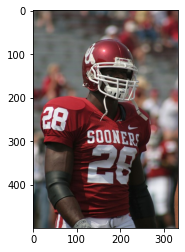

1/1 [==============================] - 0s 32ms/step

Generated Caption: black dog is running through the water with stick in his mouth and red and


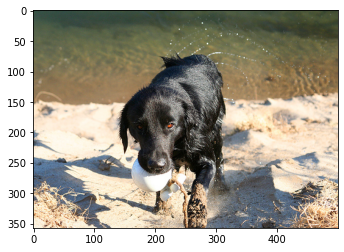

1/1 [==============================] - 0s 28ms/step

Generated Caption: basketball player in red uniform is playing basketball during game of the goal hoop in


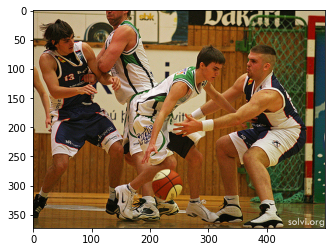

1/1 [==============================] - 0s 33ms/step

Generated Caption: two people are walking on the snowy ridge of mountains in the mountains below the


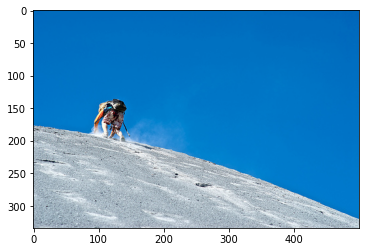

1/1 [==============================] - 0s 29ms/step

Generated Caption: skateboarder does trick on ramp with his arms crossed on the ground in front of


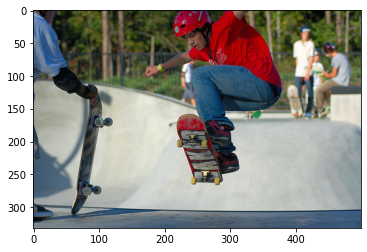

In [95]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

max_length = 32
# img_path='./Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
# img_path='./Flicker8k_Dataset/'+train_imgs[-2]
# img_path=r'C:\Users\crkpn\OneDrive\Desktop\img0.png'
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_small/model_1.h5')
model = load_model('models/model_9.h5')

xception_model = Xception(include_top=False, pooling="avg")
crt=[1,4,8,9,20,23]
# for i in range (20,25):
for i in crt:
    img_path='./Flicker8k_Dataset/'+test_imgs[i]
    photo = extract_features(img_path, xception_model)
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    words_list=description.split()[2:17]
    sentence = ' '.join(words_list)
    print("\nGenerated Caption:", sentence)
    plt.imshow(img)
    plt.show()


In [86]:
words_list=description.split()[2:17]
sentence = ' '.join(words_list)

In [87]:
sentence

'women in pink shirts are standing in front of building with baskets in the background'

In [62]:
filename = dataset_text + "/" + "Flickr_8k.testImages.txt"
test_imgs = load_photos(filename)

In [63]:
test_imgs

['3385593926_d3e9c21170.jpg',
 '2677656448_6b7e7702af.jpg',
 '311146855_0b65fdb169.jpg',
 '1258913059_07c613f7ff.jpg',
 '241347760_d44c8d3a01.jpg',
 '2654514044_a70a6e2c21.jpg',
 '2339106348_2df90aa6a9.jpg',
 '256085101_2c2617c5d0.jpg',
 '280706862_14c30d734a.jpg',
 '3072172967_630e9c69d0.jpg',
 '3482062809_3b694322c4.jpg',
 '1167669558_87a8a467d6.jpg',
 '2847615962_c330bded6e.jpg',
 '3344233740_c010378da7.jpg',
 '2435685480_a79d42e564.jpg',
 '3110649716_c17e14670e.jpg',
 '2511019188_ca71775f2d.jpg',
 '2521770311_3086ca90de.jpg',
 '2723477522_d89f5ac62b.jpg',
 '2218609886_892dcd6915.jpg',
 '3745451546_fc8ec70cbd.jpg',
 '2844018783_524b08e5aa.jpg',
 '3100251515_c68027cc22.jpg',
 '2207244634_1db1a1890b.jpg',
 '2943023421_e297f05e11.jpg',
 '3286822339_5535af6b93.jpg',
 '2479652566_8f9fac8af5.jpg',
 '1394368714_3bc7c19969.jpg',
 '872622575_ba1d3632cc.jpg',
 '2309860995_c2e2a0feeb.jpg',
 '241347204_007d83e252.jpg',
 '3502343542_f9b46688e5.jpg',
 '757332692_6866ae545c.jpg',
 '2748729903_3c7c

In [71]:
train_imgs

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117